# Árboles de decisión

Librerías:

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

Para ilustrar el proceso de construcción del árbol, consideremos un ejemplo simple. Imagine que está trabajando para un estudio de cine de Hollywood, y su escritorio está repleto de guiones. En lugar de leer cada uno de principio a fin, usted decide desarrollar un algoritmo de árbol de decisión para predecir si una película potencial podría clasificarse en una de tres categorías: 

-   impacto mainstream, 
-   amado por la crítica (critic's choice) o 
-   fracaso de taquilla (box office bust).

Después de revisar los datos de 30 guiones de películas diferentes, surge un patrón. Parece haber una relación entre el **presupuesto** de rodaje propuesto por la película, el **número de celebridades**  *A* para los papeles protagónicos y las categorías de éxito.

<img src="images/im12.png" width="500" height="300">

Para construir un árbol de decisión simple usando esta información, podemos aplicar una estrategia de *dividir y vencer*.

<img src="images/im22.png" width="700" height="300">

Resultado:

<img src="images/im3.png" width="700" height="600">

> Es posible que hayas notado que las líneas diagonales podrían haber dividido los datos aún más limpiamente. Esta es una limitación de del árbol de decisiones, que **utiliza divisiones paralelas a los ejes**. El hecho de que cada división considere **una característica a la vez** evita que el árbol de decisiones forme **decisiones más complejas**, como "si el número de celebridades es mayor que el presupuesto estimado, entonces será un éxito crítico".

Entonces, ¿qué es un árbol de decisión?

-   El modelo en sí mismo comprende una serie de decisiones lógicas, similares a un diagrama de flujo, con nodos de decisión que indican una decisión sobre un atributo. Estos se dividen en ramas que indican las elecciones de la decisión. El árbol termina con *nodos de hoja* o *leaf nodes* (también conocidos como nodos terminales) que denotan el resultado de seguir una combinación de decisiones.


| Fortalezas                                                                                                          | Debilidades                                                                                                                          |
|---------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------|
| Un clasificador multiuso que funciona bien en la mayoría de los problemas                                           | Los modelos de árbol de decisión a menudo están sesgados hacia divisiones en características que tienen una gran cantidad de niveles |
| El proceso de aprendizaje altamente automático puede manejar características numéricas o nominales, datos faltantes | Es fácil sobreajustar o ajustar el modelo                                                                                            |
| Utiliza solo las características más importantes                                                                    | Puede tener problemas para modelar algunas relaciones debido a la dependencia de divisiones paralelas al eje                         |
| Se puede usar en datos con relativamente pocos ejemplos de entrenamiento o un número muy grande                     | Pequeños cambios en los datos de entrenamiento pueden generar grandes cambios en la lógica de decisión                               |
| Resultados en un modelo que puede interpretarse sin un fondo matemático (para árboles relativamente pequeños)       | Los árboles grandes pueden ser difíciles de interpretar y las decisiones que toman pueden parecer contradictorias                    |
| Más eficiente que otros modelos complejos                                                                           |                                                                                                                                      |


## Elegir la *mejor* partición

**Entropía**

> La entropía de una muestra de datos indica qué tan mezclados están los valores de clase; el valor mínimo de 0 indica que la muestra es completamente homogénea, mientras que 1 indica la cantidad máxima de desorden.

$$
Entropy(S) = \sum_{i=1}^{c}-p_ilog_2(p_i)
$$


En la fórmula de entropía, para un segmento dado de datos $(S)$, el término $c$ se refiere al número de diferentes **niveles de clase**, y $p_i$ se refiere a la proporción de valores que caen en el nivel de clase $i$. Por ejemplo, supongamos que tenemos una partición de datos con dos clases: rojo ($60$ por ciento) y blanco ($40$ por ciento). Podemos calcular la entropía como:

In [2]:
import math

# Valores
p1 = 0.60
p2 = 0.40

# Calculo
result = -p1 * math.log2(p1) - p2 * math.log2(p2)

# Resultado
print(result)

0.9709505944546686


Podemos examinar la entropía para todos los posibles arreglos de dos clases. Si sabemos que la proporción de ejemplos en una clase es $x$, entonces la proporción en la otra clase es $1 - x$. 

Creamos la función `entropy` y creamos valores para `x` de modo que se pueda visualizar la función:

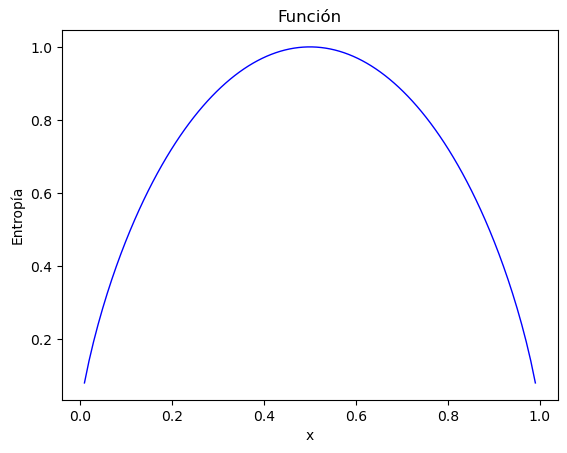

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Definimos la funcion entropia
def entropy(x):
    return -x * np.log2(x) - (1 - x) * np.log2(1 - x)

# Generar valores x de 0 a 1
x_values = np.linspace(0.01, 0.99, 100)

# Calculamos la entropia para cada x
y_values = entropy(x_values)

# Plot
plt.plot(x_values, y_values, color='blue', linewidth=1)
plt.xlabel('x')
plt.ylabel('Entropía')
plt.title('Función')
plt.show()

Como se ilustra por el pico en entropía en $x = 0.50$, una división $50-50$ da como resultado la **entropía máxima**. A medida que una clase domina cada vez más a la otra, la entropía se reduce a cero.


Dada esta medida de pureza (como la entropía), el algoritmo aún debe **decidir qué característica dividir**. Para esto, el algoritmo usa la entropía para calcular el cambio en la homogeneidad resultante de una división en cada característica posible. El cálculo se conoce como **ganancia de información**. La ganancia de información para una característica $F$ se calcula como la diferencia entre la entropía en el segmento antes de la división $(S_1)$ y las particiones resultantes de la división $(S_2)$

$$
InfoGain (F) = Entropy(S_1)-Entropy(S_2)
$$

Cuanto mayor sea la ganancia de información, mejor será una función para crear grupos homogéneos después de una división en esa función.


> La **ganancia de información no es el único** criterio de división que se puede usar para construir árboles de decisión. Otros criterios comúnmente utilizados son el **índice de Gini**, la **relación de ganancia**, entre otros. Para profundizar en estos criterios revisa: [link](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

## Ejemplo: Identificando el riesgo de un préstamo

### Paso 1: recopilación de datos

Los datos representan los préstamos obtenidos de una agencia de crédito en Alemania.

In [4]:
# Cargar los datos
url = "https://github.com/vmoprojs/DataLectures/raw/master/credit.csv"
credit = pd.read_csv(url)

El conjunto de datos crediticios incluye $1000$ ejemplos de préstamos, más una combinación de características numéricas y nominales que indican las características del préstamo y del solicitante del préstamo.

Una variable indica si el préstamo **entró en default**. Veamos si podemos determinar un patrón que prediga este resultado.

### Paso 2: Explorar y preparar los datos

Veamos algunos de los resultados de `table()` para un par de características de préstamos que **parecen predecir un incumplimiento**. Las características `checking_balance` y `savings_balance` indican el saldo de la cuenta de cheques y de ahorros del solicitante, y se registran como variables categóricas:

In [5]:
# Ver estructura de los datos
print(credit.info())

# Tablas de frecuencia para balance de cuenta corriente y de ahorros
print(credit['checking_balance'].value_counts())
print(credit['savings_balance'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   checking_balance      1000 non-null   object
 1   months_loan_duration  1000 non-null   int64 
 2   credit_history        1000 non-null   object
 3   purpose               1000 non-null   object
 4   amount                1000 non-null   int64 
 5   savings_balance       1000 non-null   object
 6   employment_duration   1000 non-null   object
 7   percent_of_income     1000 non-null   int64 
 8   years_at_residence    1000 non-null   int64 
 9   age                   1000 non-null   int64 
 10  other_credit          1000 non-null   object
 11  housing               1000 non-null   object
 12  existing_loans_count  1000 non-null   int64 
 13  job                   1000 non-null   object
 14  dependents            1000 non-null   int64 
 15  phone                 1000 non-null   o

Dado que los datos del préstamo se obtuvieron de Alemania, la moneda se registra en *Deutsche Marks (DM)*. Parece una suposición válida que los saldos de cuentas corrientes y de **ahorro más grandes** deberían estar relacionados con una **menor posibilidad de impago** del préstamo.

Algunas de las funciones del préstamo son numéricas, como su plazo (`months_loan_duration`) y el monto de crédito solicitado (`amount`).

In [6]:
# Resumen de la duración del préstamo
print(credit['months_loan_duration'].describe())

count    1000.000000
mean       20.903000
std        12.058814
min         4.000000
25%        12.000000
50%        18.000000
75%        24.000000
max        72.000000
Name: months_loan_duration, dtype: float64


Los montos de los préstamos oscilaron entre 250 DM y 18420 DM a plazos de 4 a 72 meses, con una duración media de 18 meses y un monto de 2320 DM.

La variable `default` indica si el solicitante del préstamo no pudo cumplir con los términos de pago acordados y entró en incumplimiento. Un total del 30 por ciento de los préstamos entraron en mora:

In [7]:
# Tabla de frecuencia para el valor predicho (default)
print(credit['default'].value_counts())

default
no     700
yes    300
Name: count, dtype: int64


Una alta tasa de incumplimiento no es deseable para un banco porque significa que es poco probable que el banco recupere completamente su inversión. Si tenemos éxito, nuestro **modelo identificará a los solicitantes que es probable que presenten un incumplimiento**, tal que este número se pueda reducir.

**Creamos el conjunto de entrenamiento y de prueba**

1.   ordenar al azar su data de crédito antes de dividir.

In [8]:
# Barajar las filas de forma aleatoria
np.random.seed(12345)
credit_rand = credit.sample(frac=1).reset_index(drop=True)


Confirmamos que los datos no han cambiado

In [9]:
# Resumen del monto del préstamo
print(credit['amount'].describe())

count     1000.000000
mean      3271.258000
std       2822.736876
min        250.000000
25%       1365.500000
50%       2319.500000
75%       3972.250000
max      18424.000000
Name: amount, dtype: float64


2.    Ahora, podemos dividir los datos en entrenamiento (90 por ciento o 900 registros) y datos de prueba (10 por ciento o 100 registros)

In [10]:
# Dividir en conjunto de entrenamiento y prueba
credit_train = credit_rand.iloc[:900, :]
credit_test = credit_rand.iloc[900:, :]

Si todo salió bien, deberíamos tener alrededor del 30 por ciento de los préstamos impagos en cada uno de los conjuntos de datos.

In [11]:
# Proporciones de la variable 'default' en entrenamiento y prueba
print(credit_train['default'].value_counts(normalize=True))
print(credit_test['default'].value_counts(normalize=True))

default
no     0.707778
yes    0.292222
Name: proportion, dtype: float64
default
no     0.63
yes    0.37
Name: proportion, dtype: float64


### Paso 3: entrenar un modelo en los datos

La columna 17 en `credit_train` es la variable `default`, por lo que debemos excluirla del `DataFrame` de entrenamiento como una variable independiente, pero considerarla como dependiente para la clasificación.

Debemos separar los datos y seleccionar las variables con las que vamos a trabajar

In [12]:
# Seleccionar las características y el objetivo
features = ['checking_balance', 'months_loan_duration', 'credit_history', 'purpose', 'amount', 'savings_balance', 
            'employment_duration', 'percent_of_income', 'years_at_residence', 'age', 'other_credit', 'housing', 
            'existing_loans_count', 'job', 'dependents', 'phone']
X_train = credit_train[features]
y_train = credit_train['default']
X_test = credit_test[features]
y_test = credit_test['default']

In [13]:
# Codificar las variables categóricas
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


#Definir las listas de categóricas y numéricas
numeric_features = ['months_loan_duration', 'amount','age']
categorical_features = ['checking_balance',  'credit_history', 'purpose','savings_balance', 
            'employment_duration', 'percent_of_income', 'years_at_residence', 'other_credit', 'housing', 
            'existing_loans_count', 'job', 'dependents', 'phone']

#Standscaler a caracteristicas numericas y Onehotencoder a las categoricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing or unknown categorical values
            ('onehot', OneHotEncoder(handle_unknown='ignore'))     # OneHotEncode the categorical features
        ]), categorical_features)
    ])

#Crear un pipeline con preprocesador y  modelo
model = Pipeline(steps=[('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(
            random_state=12345,
            criterion='entropy',
        max_depth=3))])



Entrenamos el modelo:

In [14]:
# Entrenar el modelo de árbol de decisión
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['months_loan_duration',
                                                   'amount', 'age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['checking_balance',
                                                   'credit_history', 'purpose',
                                                   'savings_balance',
                                                   'employment_duration',
                                                   'percent_of_income',
                                                   'years_at_residence',
                                                   'other_credit', 'housing',
                                                   'existing_loans_count',
                                                   'job', 'dependents',
                                                   'phone'])])),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3,
                                        random_state=12345))])

In [15]:
# Extraer el modelo de árbol de decisión ajustado
decision_tree = model.named_steps['classifier']

# Asegurarte de que el modelo es el DecisionTreeClassifier
print(type(decision_tree))

# Obtener los nombres de las características como una lista
feature_names = preprocessor.get_feature_names_out().tolist()

from sklearn.tree import export_text
# Imprimir el árbol de decisión como texto
tree_text = export_text(decision_tree, feature_names=feature_names)
print(tree_text)

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
|--- cat__checking_balance_unknown <= 0.50
|   |--- num__months_loan_duration <= 0.15
|   |   |--- cat__credit_history_very good <= 0.50
|   |   |   |--- class: no
|   |   |--- cat__credit_history_very good >  0.50
|   |   |   |--- class: yes
|   |--- num__months_loan_duration >  0.15
|   |   |--- cat__savings_balance_< 100 DM <= 0.50
|   |   |   |--- class: no
|   |   |--- cat__savings_balance_< 100 DM >  0.50
|   |   |   |--- class: yes
|--- cat__checking_balance_unknown >  0.50
|   |--- cat__other_credit_none <= 0.50
|   |   |--- cat__purpose_furniture/appliances <= 0.50
|   |   |   |--- class: yes
|   |   |--- cat__purpose_furniture/appliances >  0.50
|   |   |   |--- class: no
|   |--- cat__other_credit_none >  0.50
|   |   |--- cat__credit_history_critical <= 0.50
|   |   |   |--- class: no
|   |   |--- cat__credit_history_critical >  0.50
|   |   |   |--- class: no



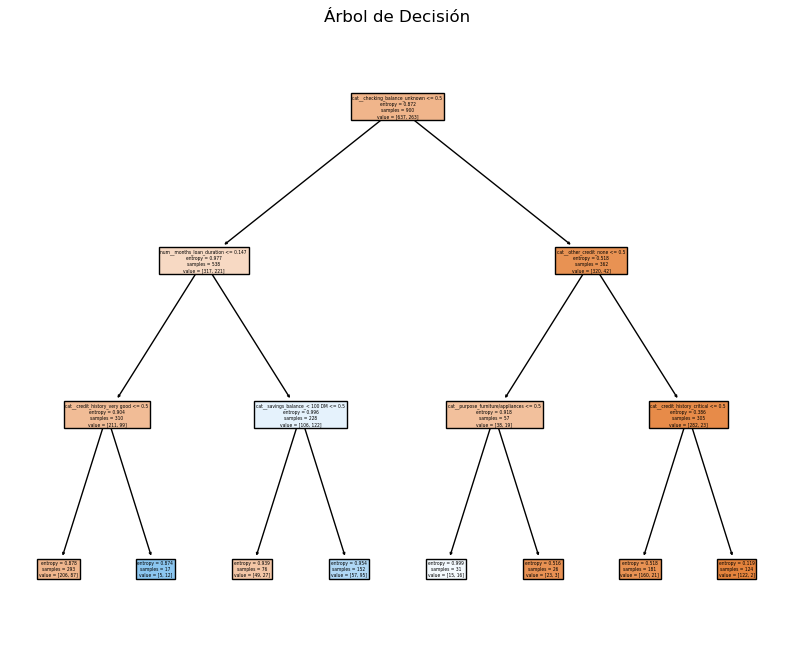

In [16]:
# Graficar el árbol de decisión
plt.figure(figsize=(10, 8))
plot_tree(decision_tree, filled=True, feature_names=feature_names)
plt.title("Árbol de Decisión")
plt.show()

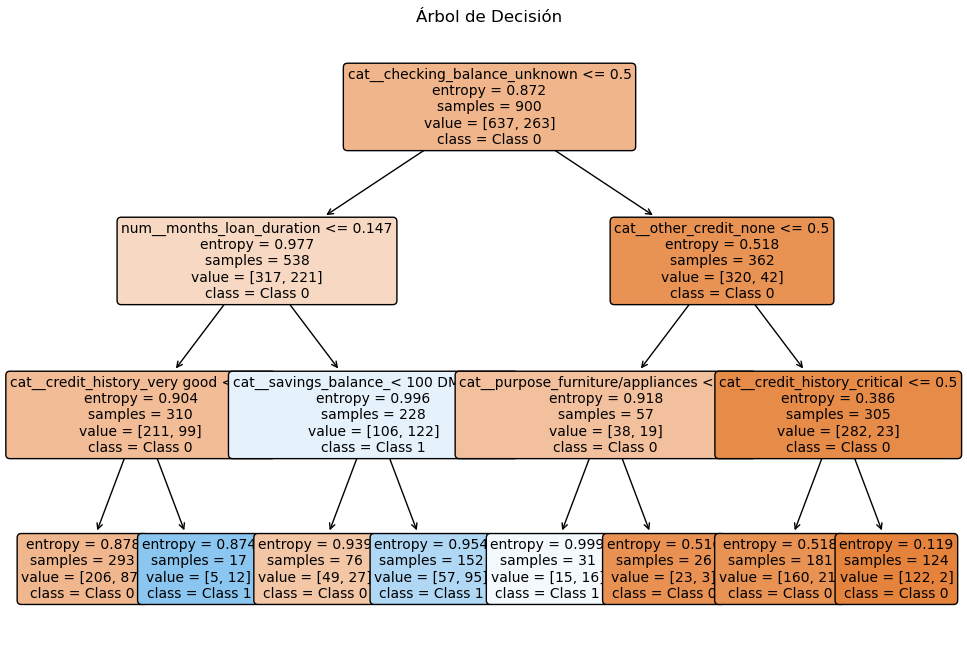

In [17]:
from sklearn import tree
# Función para graficar el árbol
def plot_decision_tree(model):
    plt.figure(figsize=(12, 8))
    tree.plot_tree(model, filled=True, rounded=True, 
                   feature_names=feature_names, 
                   class_names=['Class 0', 'Class 1'], 
                   fontsize=10)
    plt.title("Árbol de Decisión")
    plt.show()

# Llamar a la función para graficar
plot_decision_tree(decision_tree)


### Paso 4: evaluar el rendimiento del modelo

In [18]:
# Predecir con el conjunto de prueba
credit_pred = model.predict(X_test)
credit_pred_prob = model.predict_proba(X_test)[:, 1]

In [19]:
# Matriz de confusión y reportes de clasificación
conf_matrix = confusion_matrix(y_test, credit_pred)
class_report = classification_report(y_test, credit_pred)


In [20]:
print(conf_matrix)
print(class_report)

[[51 12]
 [26 11]]
              precision    recall  f1-score   support

          no       0.66      0.81      0.73        63
         yes       0.48      0.30      0.37        37

    accuracy                           0.62       100
   macro avg       0.57      0.55      0.55       100
weighted avg       0.59      0.62      0.59       100



In [21]:
# Proporciones de la matriz de confusión
conf_matrix_norm1 = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix_norm2 = conf_matrix.astype('float') / conf_matrix.sum(axis=0)[np.newaxis, :]


In [22]:
print(conf_matrix_norm1)
print(conf_matrix_norm2)

[[0.80952381 0.19047619]
 [0.7027027  0.2972973 ]]
[[0.66233766 0.52173913]
 [0.33766234 0.47826087]]


## Mejorando la estimación

La definición de la medida de complejidad-costo (cost-complexity measure):

Para cualquier subárbol $T < T_{max}$, definiremos su complejidad como $|\tilde{T}|$, el número de nodos terminales u hoja en $T$ . Sea $\alpha ≥ 0$ un número real llamado parámetro de complejidad y defina la medida de costo-complejidad $R_{\alpha}(T)$ como:

$$
R_{\alpha}(T)=R(T) +\alpha| \tilde{T}|
$$


Cuantos más nodos de hoja (nodos sin hijos) contenga el árbol, mayor será su complejidad porque tenemos más flexibilidad para dividir el espacio en partes más pequeñas y, por lo tanto, más posibilidades para ajustar los datos de entrenamiento. También está la cuestión de cuánta importancia darle al tamaño del árbol. El parámetro de complejidad $\alpha$ ajusta eso.

Al final, la medida de la complejidad-costo surge como una versión penalizada de la tasa de error de resustitución. Esta es la función a minimizar al podar el árbol.

Qué árbol seleccionar a final depende de $\alpha$. Si $\alpha=0$ entonces el árbol más grande será elegido porque el término de complejidad se anula. Si $\alpha \to \infty$, se elige un solo nodo.

In [23]:
# Obtener los valores de ccp_alpha para la poda
X_train_transformed = model.named_steps['preprocessor'].transform(X_train)
path = decision_tree.cost_complexity_pruning_path(X_train_transformed, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities


In [24]:
# Entrenar árboles de decisión con diferentes valores de ccp_alpha
clfs = []
for ccp_alpha in ccp_alphas:
    # clf = DecisionTreeClassifier(random_state=12345, ccp_alpha=ccp_alpha,class_weight="balanced")
    clf = DecisionTreeClassifier(random_state=12345, ccp_alpha=ccp_alpha,criterion='entropy')
    clf.fit(X_train_transformed, y_train)
    clfs.append(clf)

In [25]:
# Seleccionar el mejor árbol basado en la precisión de validación cruzada
X_test_transformed = model.named_steps['preprocessor'].transform(X_test)
train_scores = [clf.score(X_train_transformed, y_train) for clf in clfs]
test_scores = [clf.score(X_test_transformed, y_test) for clf in clfs]


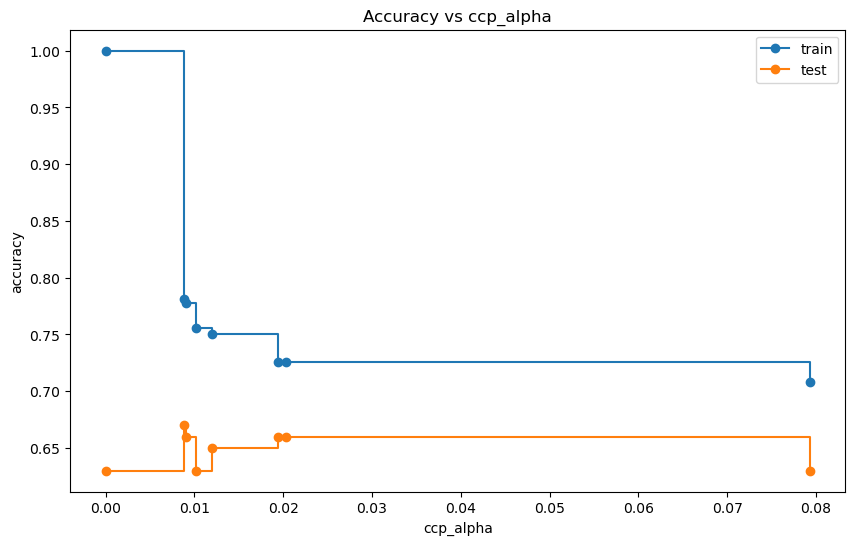

In [26]:
# Graficar la precisión del entrenamiento y la prueba en función de ccp_alpha
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("accuracy")
plt.legend()
plt.title("Accuracy vs ccp_alpha")
plt.show()

In [27]:
# Seleccionar el mejor modelo basado en el rendimiento de la prueba
best_index = np.argmax(test_scores)
best_ccp_alpha = ccp_alphas[best_index]
best_model = clfs[best_index]

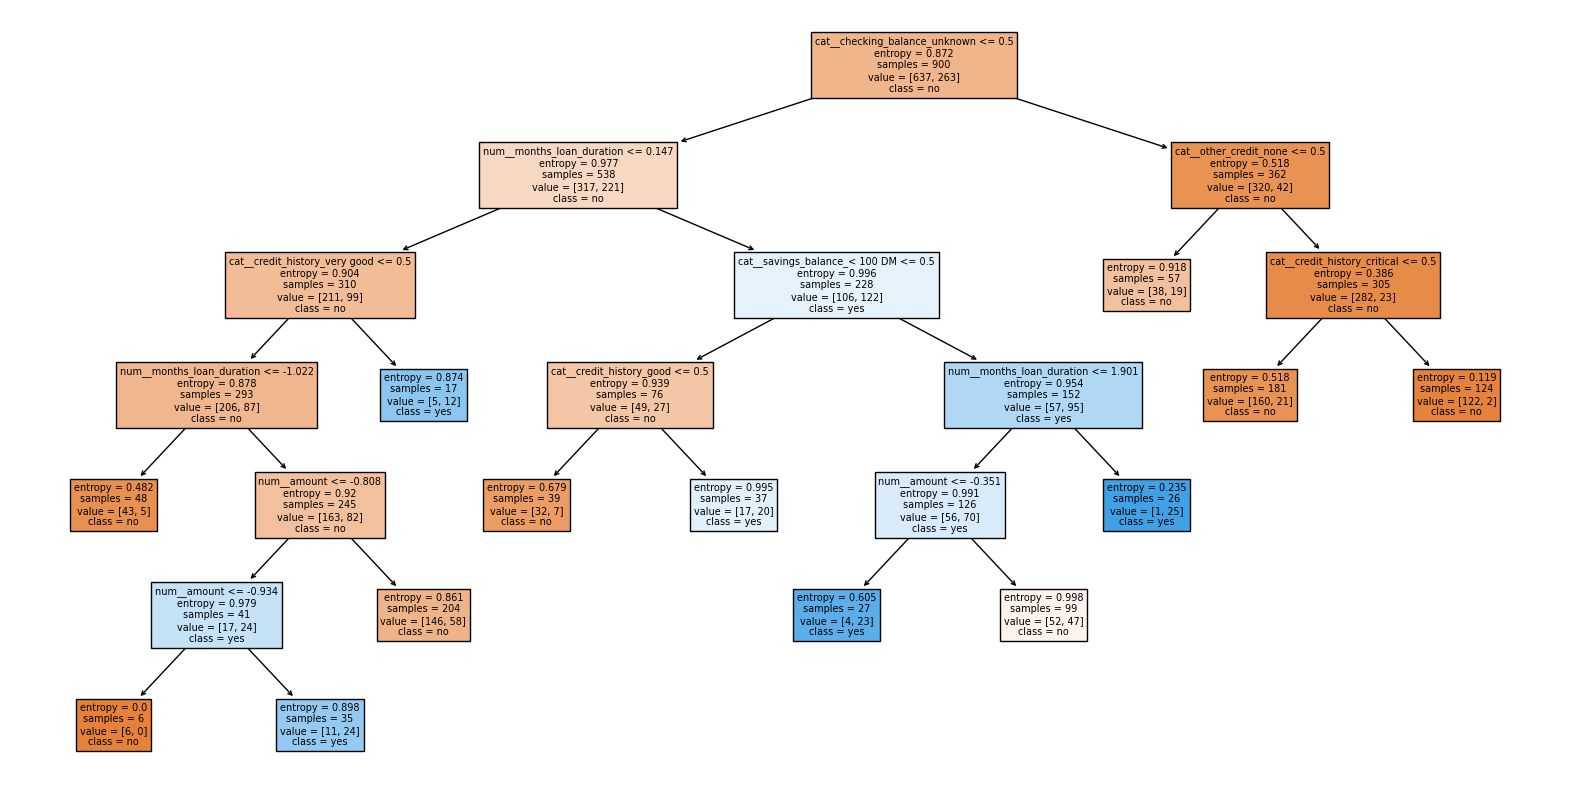

In [28]:
# Imprimir el mejor modelo (el árbol de decisión podado)
plt.figure(figsize=(20,10))
plot_tree(best_model, feature_names=feature_names, class_names=['no', 'yes'], filled=True)
plt.show()

In [29]:
# Predecir con el conjunto de prueba usando el mejor modelo
credit_pred = best_model.predict(X_test_transformed)

In [30]:
# Matriz de confusión y reportes de clasificación
conf_matrix = confusion_matrix(y_test, credit_pred)
class_report = classification_report(y_test, credit_pred)


In [31]:
print(conf_matrix)
print(class_report)

[[55  8]
 [25 12]]
              precision    recall  f1-score   support

          no       0.69      0.87      0.77        63
         yes       0.60      0.32      0.42        37

    accuracy                           0.67       100
   macro avg       0.64      0.60      0.60       100
weighted avg       0.66      0.67      0.64       100



In [32]:
# Proporciones de la matriz de confusión
conf_matrix_norm1 = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix_norm2 = conf_matrix.astype('float') / conf_matrix.sum(axis=0)[np.newaxis, :]

print(conf_matrix_norm1)
print(conf_matrix_norm2)

[[0.87301587 0.12698413]
 [0.67567568 0.32432432]]
[[0.6875 0.4   ]
 [0.3125 0.6   ]]
